![](https://rumc-gcorg-p-public.s3.amazonaws.com/i/2024/04/20/image.png)

In [5]:
import SimpleITK as sitk
from dotenv import load_dotenv
from dotenv import dotenv_values
from glob import glob
from pathlib import Path
import os
import numpy as np
import yaml
from tqdm import tqdm
import matplotlib.pyplot as plt
from acouslic_utils import *

In [2]:
env = dotenv_values(".env")
print(env)

consts = None
with open('consts.yaml') as f:
    try:
        consts = yaml.safe_load(f)
    except yaml.YAMLError as exc:
        print(exc)    
consts

OrderedDict([('DS_RAW', '/mnt/Enterprise2/PUBLIC_DATASETS/acouslic-ai/')])


{'OPTIMAL': 1,
 'SUBOPTIMAL': 2,
 'TOTAL_FRAMECOUNT': 840,
 'TOTAL_SWEEPS': 6,
 'singlestack_dir': 'single_stack'}

In [3]:
image_dir = Path(env['DS_RAW'])/'images'
image_paths = sorted(image_dir.rglob('*.mha'))

mask_dir =  Path(env['DS_RAW'])/'masks'
mask_paths = sorted(mask_dir.rglob('*.mha'))

In [4]:
mask_np = sitk_to_numpy(read_image(mask_paths[0]))

In [5]:
mask_np.shape

(744, 562, 840)

In [7]:
get_optimal_frame_number(mask_np,optimal_label=consts['OPTIMAL'])

array([], dtype=int64)

In [8]:
a = get_suboptimal_frame_number(mask_np, suboptimal_label=consts['SUBOPTIMAL'])

In [19]:
assert frame_index_to_sweep_id(0,   mask_np.shape[-1])['sweep_id'] == 1
assert frame_index_to_sweep_id(140, mask_np.shape[-1])['sweep_id'] == 2
assert frame_index_to_sweep_id(839, mask_np.shape[-1]) ['sweep_id']== 6
frame_index_to_sweep_id(0,840), frame_index_to_sweep_id(140,840), frame_index_to_sweep_id(839,840)

({'sweep_id': 1, 'frame_id': 0},
 {'sweep_id': 2, 'frame_id': 0},
 {'sweep_id': 6, 'frame_id': 139})

In [9]:
a = []
if a:
    print('somehint')
else:
    print('empty')

empty


In [11]:
def get_stats_row(mask_path):
    mask_np = sitk_to_numpy(read_image(mask_path))

    file_stem = get_stem(mask_path)

    subopt_seq = to_index_sequence_contiguous(get_suboptimal_frame_number(mask_np))
    opt_seq = to_index_sequence_contiguous(get_optimal_frame_number(mask_np))

    has_opt = True if opt_seq else False
    has_subopt = True if subopt_seq else False

    data_stats =  {'file_stem':file_stem, 'has_opt':has_opt, 'has_subopt': has_subopt, 'opt_seq':opt_seq, 'subopt_seq': subopt_seq}
    
    return data_stats

In [6]:
from typing import List


def get_seq_len_per_sweep(seq:List):
    seq_lens = {}
    for s,e in seq:
        seq_len = e-s+1
        start_idx_dict = frame_index_to_sweep_id(s,840,6)
        end_idx_dict = frame_index_to_sweep_id(e,840,6)
        seq_lens[start_idx_dict['sweep_id']] = seq_len
    return seq_lens

In [8]:
get_seq_len_per_sweep([(62,66)])
get_seq_len_per_sweep([(60, 70), (619, 626)])

{1: 11, 5: 8}

In [12]:
get_stats_row(mask_paths[0])

{'file_stem': '0199616b-bdeb-4119-97a3-a5a3571bd641',
 'has_opt': False,
 'has_subopt': True,
 'opt_seq': [],
 'subopt_seq': [(60, 70), (619, 626)]}

In [11]:
type("hello")

str

In [12]:
type("hello") == str

True

In [20]:
file_stems =[]
has_opt = []
has_subopt = []

opt_frame_counts = []
subopt_frame_counts = []

opt_seqs = []
opt_seqs_len = []

subopt_seqs_len = []
subopt_seqs = []
for path in tqdm(mask_paths):
    # read image
    mask = read_image(path)
    mask_np = sitk_to_numpy(mask)

    # get optimal/suboptimal sequence
    subopt_seq = to_index_sequence_contiguous(get_suboptimal_frame_number(mask_np))
    opt_seq = to_index_sequence_contiguous(get_optimal_frame_number(mask_np))

    file_stem = get_stem(path)
    file_stems.append(file_stem)
    subopt_seqs.append(subopt_seq)
    opt_seqs.append(opt_seq)
    
    subopt_seq_len = len(subopt_seq)
    opt_seq_len = len(opt_seq)

    has_optimal_frame = len(opt_seq) != 0
    has_opt.append(has_optimal_frame)
    
    opt_seqs_len.append(opt_seq_len)
    subopt_seqs_len.append(subopt_seq_len)

    opt_frame_count = np.sum([ e-s for s,e in opt_seq])
    subopt_frame_count = np.sum([e-s for s,e in subopt_seq])

    opt_frame_counts.append(opt_frame_count)
    subopt_frame_counts.append(subopt_frame_count)

    print(f'{file_stem} Has_Optimal:{has_optimal_frame} opt_frame_count:{opt_frame_count} subopt_frame_count: {subopt_frame_count} opt_seq: {opt_seq_len} subopt_seq: {subopt_seq_len} {subopt_seq} {opt_seq} ')


  0%|          | 1/300 [00:01<09:56,  2.00s/it]

0199616b-bdeb-4119-97a3-a5a3571bd641 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 17 opt_seq: 0 subopt_seq: 2 [(60, 70), (619, 626)] [] 


  1%|          | 2/300 [00:03<09:13,  1.86s/it]

02d3a9bc-63e2-4deb-9dc1-dba17e7d54c1 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 4 opt_seq: 0 subopt_seq: 1 [(62, 66)] [] 


  1%|          | 3/300 [00:05<09:04,  1.83s/it]

02ee26a5-a665-4531-bec1-8bac83345a94 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 8 opt_seq: 0 subopt_seq: 1 [(50, 58)] [] 


  1%|▏         | 4/300 [00:07<09:14,  1.87s/it]

032b9024-3685-4a81-a62e-813d2da3d387 Has_Optimal:True opt_frame_count:16 subopt_frame_count: 19 opt_seq: 1 subopt_seq: 3 [(17, 22), (172, 180), (487, 493)] [(494, 510)] 


  2%|▏         | 5/300 [00:09<09:18,  1.89s/it]

0428da3d-fef4-4c9b-96f2-5ffedaee82d0 Has_Optimal:True opt_frame_count:8 subopt_frame_count: 5 opt_seq: 1 subopt_seq: 1 [(69, 74)] [(60, 68)] 


  2%|▏         | 6/300 [00:11<09:29,  1.94s/it]

046ed03e-4b35-4519-bb5f-cd4b0474a060 Has_Optimal:True opt_frame_count:13 subopt_frame_count: 4 opt_seq: 1 subopt_seq: 1 [(69, 73)] [(55, 68)] 


  2%|▏         | 7/300 [00:14<11:30,  2.36s/it]

04a04f2e-840b-47f8-a907-abe7aeab3f41 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 31 opt_seq: 0 subopt_seq: 2 [(39, 61), (204, 213)] [] 


  3%|▎         | 8/300 [00:27<28:04,  5.77s/it]

04ef1176-7d54-4942-899d-f0fa69ad34bb Has_Optimal:True opt_frame_count:29 subopt_frame_count: 6 opt_seq: 3 subopt_seq: 4 [(27, 27), (38, 38), (202, 202), (509, 515)] [(28, 37), (186, 201), (516, 521)] 


  3%|▎         | 9/300 [00:40<37:57,  7.83s/it]

056764b4-7c0c-4452-832d-3d1cbb5a0464 Has_Optimal:True opt_frame_count:14 subopt_frame_count: 9 opt_seq: 2 subopt_seq: 3 [(55, 55), (182, 186), (338, 343)] [(45, 54), (344, 349)] 


  3%|▎         | 10/300 [00:42<29:02,  6.01s/it]

05f72776-bf41-40ea-bdea-a7bcfa1eb9ba Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 7 opt_seq: 0 subopt_seq: 1 [(357, 364)] [] 


  4%|▎         | 11/300 [00:44<22:59,  4.77s/it]

0607eff0-2268-46b6-8fb8-16e40a521a42 Has_Optimal:True opt_frame_count:2 subopt_frame_count: 12 opt_seq: 1 subopt_seq: 2 [(46, 53), (179, 184)] [(176, 178)] 


  4%|▍         | 12/300 [00:46<18:56,  3.95s/it]

0658cdf9-53bc-46a9-ae86-cc99a6fc5e77 Has_Optimal:True opt_frame_count:13 subopt_frame_count: 13 opt_seq: 1 subopt_seq: 1 [(617, 630)] [(62, 75)] 


  4%|▍         | 13/300 [00:47<15:49,  3.31s/it]

0685cfaf-d585-40b3-a365-52f70f2536b6 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 2 opt_seq: 0 subopt_seq: 1 [(218, 220)] [] 


  5%|▍         | 14/300 [00:49<13:57,  2.93s/it]

069c0349-1e8d-42d0-afa1-69c7114a742f Has_Optimal:True opt_frame_count:9 subopt_frame_count: 25 opt_seq: 1 subopt_seq: 3 [(176, 191), (319, 328), (801, 802)] [(56, 65)] 


  5%|▌         | 15/300 [00:51<12:22,  2.60s/it]

071ee12c-a8a5-45fd-b191-fd5ec3b00766 Has_Optimal:True opt_frame_count:1 subopt_frame_count: 31 opt_seq: 1 subopt_seq: 3 [(201, 210), (502, 510), (641, 655)] [(53, 54)] 


  5%|▌         | 16/300 [00:53<11:26,  2.42s/it]

09ddeecb-72e0-417a-85fd-77d397f6219d Has_Optimal:True opt_frame_count:19 subopt_frame_count: 22 opt_seq: 2 subopt_seq: 4 [(50, 53), (212, 214), (510, 524), (639, 642)] [(206, 211), (610, 624)] 


  6%|▌         | 17/300 [00:55<10:53,  2.31s/it]

0d0a3298-a9c6-43c3-a9e3-df3a9c0afa06 Has_Optimal:True opt_frame_count:4 subopt_frame_count: 27 opt_seq: 1 subopt_seq: 3 [(309, 311), (469, 479), (603, 618)] [(45, 49)] 


  6%|▌         | 18/300 [00:57<10:14,  2.18s/it]

0d7c4d8f-6e07-4f2b-aa76-8915ce15a38f Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 15 opt_seq: 0 subopt_seq: 2 [(29, 32), (302, 314)] [] 


  6%|▋         | 19/300 [00:59<10:03,  2.15s/it]

0e2631b6-ed14-4ce4-bc17-896590c406fd Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 42 opt_seq: 0 subopt_seq: 2 [(45, 70), (220, 237)] [] 


  7%|▋         | 20/300 [01:01<09:51,  2.11s/it]

0f32e98f-8257-4649-a8a2-3cccb2c1a2e5 Has_Optimal:True opt_frame_count:4 subopt_frame_count: 17 opt_seq: 1 subopt_seq: 1 [(289, 306)] [(19, 23)] 


  7%|▋         | 21/300 [01:03<09:32,  2.05s/it]

1269a6c4-7f04-4927-9308-e4fd68883906 Has_Optimal:True opt_frame_count:10 subopt_frame_count: 16 opt_seq: 1 subopt_seq: 2 [(30, 39), (163, 170)] [(305, 315)] 


  7%|▋         | 22/300 [01:05<09:18,  2.01s/it]

12941223-b27c-47f5-bcb0-7f7bfba18bba Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 8 opt_seq: 0 subopt_seq: 1 [(50, 58)] [] 


  8%|▊         | 23/300 [01:07<09:18,  2.02s/it]

136db39d-90e4-4702-aee7-dc5cd3169268 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 22 opt_seq: 0 subopt_seq: 1 [(58, 80)] [] 


  8%|▊         | 24/300 [01:09<09:09,  1.99s/it]

1613944c-ea48-4953-84e9-953b9d86f175 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 5 opt_seq: 0 subopt_seq: 1 [(46, 51)] [] 


  8%|▊         | 25/300 [01:11<09:27,  2.07s/it]

177786dd-a8f4-4d57-ac1b-13811480bd09 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 26 opt_seq: 0 subopt_seq: 3 [(22, 34), (157, 165), (304, 310)] [] 


  9%|▊         | 26/300 [01:13<09:19,  2.04s/it]

17b31515-75fb-41fc-8908-7c0264d21204 Has_Optimal:True opt_frame_count:7 subopt_frame_count: 24 opt_seq: 1 subopt_seq: 2 [(44, 53), (325, 340)] [(54, 61)] 


  9%|▉         | 27/300 [01:16<09:29,  2.09s/it]

19202c0a-fade-4c7a-9878-e91d823963d6 Has_Optimal:True opt_frame_count:8 subopt_frame_count: 13 opt_seq: 1 subopt_seq: 2 [(48, 51), (333, 343)] [(39, 47)] 


  9%|▉         | 28/300 [01:17<09:07,  2.01s/it]

1a998ef3-797f-4a17-9aa6-96cfb9af87c9 Has_Optimal:True opt_frame_count:7 subopt_frame_count: 33 opt_seq: 1 subopt_seq: 3 [(38, 41), (153, 170), (292, 305)] [(42, 49)] 


 10%|▉         | 29/300 [01:19<09:11,  2.03s/it]

1af7894a-9f0a-41e8-9c10-a11c0341a93e Has_Optimal:True opt_frame_count:10 subopt_frame_count: 30 opt_seq: 1 subopt_seq: 2 [(193, 207), (321, 337)] [(50, 60)] 


 10%|█         | 30/300 [01:22<09:14,  2.05s/it]

1b250c39-7217-4921-838b-ed2681ebfef2 Has_Optimal:True opt_frame_count:5 subopt_frame_count: 0.0 opt_seq: 1 subopt_seq: 0 [] [(188, 193)] 


 10%|█         | 31/300 [01:24<09:06,  2.03s/it]

1b3db504-c1fe-45f0-96dc-3cfb851d5bca Has_Optimal:True opt_frame_count:4 subopt_frame_count: 0.0 opt_seq: 1 subopt_seq: 0 [] [(70, 74)] 


 11%|█         | 32/300 [01:26<09:04,  2.03s/it]

1c1a1114-3e30-436b-b656-101e6050ea32 Has_Optimal:True opt_frame_count:8 subopt_frame_count: 49 opt_seq: 1 subopt_seq: 2 [(192, 211), (658, 688)] [(94, 102)] 


 11%|█         | 33/300 [01:28<09:02,  2.03s/it]

1cd004a2-94fb-429a-9e14-fc950bbd8852 Has_Optimal:True opt_frame_count:19 subopt_frame_count: 0.0 opt_seq: 2 subopt_seq: 0 [] [(52, 61), (213, 223)] 


 11%|█▏        | 34/300 [01:29<08:46,  1.98s/it]

1d25be5c-d4ba-48bf-afd4-a133581f8491 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 6 opt_seq: 0 subopt_seq: 1 [(74, 80)] [] 


 12%|█▏        | 35/300 [01:32<08:54,  2.02s/it]

1d479820-767b-4d0f-b6cf-12ec5d3a26e7 Has_Optimal:True opt_frame_count:3 subopt_frame_count: 9 opt_seq: 1 subopt_seq: 2 [(52, 56), (61, 66)] [(57, 60)] 


 12%|█▏        | 36/300 [01:34<08:47,  2.00s/it]

1dab0e37-e5e4-41d4-b132-32103b385c78 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 29 opt_seq: 0 subopt_seq: 2 [(42, 64), (609, 616)] [] 


 12%|█▏        | 37/300 [01:36<08:49,  2.01s/it]

1dc4fda1-c351-4f4f-8df8-9bb35eb46062 Has_Optimal:True opt_frame_count:8 subopt_frame_count: 13 opt_seq: 1 subopt_seq: 3 [(41, 43), (193, 202), (336, 338)] [(44, 52)] 


 13%|█▎        | 38/300 [01:38<08:48,  2.02s/it]

1dccf454-18df-4bfb-b7bf-92acbea3d8e1 Has_Optimal:True opt_frame_count:8 subopt_frame_count: 11 opt_seq: 1 subopt_seq: 2 [(12, 14), (465, 474)] [(475, 483)] 


 13%|█▎        | 39/300 [01:40<08:48,  2.02s/it]

1e927a7e-90cd-475b-848d-6dc6368f42ca Has_Optimal:True opt_frame_count:11 subopt_frame_count: 0.0 opt_seq: 1 subopt_seq: 0 [] [(182, 193)] 


 13%|█▎        | 40/300 [01:42<08:52,  2.05s/it]

1f002210-be79-4c02-b948-7c27c5fd2f1e Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 1 opt_seq: 0 subopt_seq: 1 [(43, 44)] [] 


 14%|█▎        | 41/300 [01:44<08:42,  2.02s/it]

1ff3221d-43d3-4065-9393-347f2d0edac0 Has_Optimal:True opt_frame_count:2 subopt_frame_count: 1 opt_seq: 1 subopt_seq: 1 [(121, 122)] [(118, 120)] 


 14%|█▍        | 42/300 [01:46<08:50,  2.06s/it]

20a2b2a1-c91e-4ee0-93b6-c0d8fe2212db Has_Optimal:True opt_frame_count:3 subopt_frame_count: 2 opt_seq: 1 subopt_seq: 3 [(190, 190), (323, 324), (814, 815)] [(54, 57)] 


 14%|█▍        | 43/300 [01:48<08:35,  2.00s/it]

21127c13-cd7f-456b-ad07-71531d1cb054 Has_Optimal:True opt_frame_count:18 subopt_frame_count: 23 opt_seq: 2 subopt_seq: 3 [(47, 49), (140, 147), (299, 313)] [(50, 53), (148, 163)] 


 15%|█▍        | 44/300 [01:50<08:38,  2.03s/it]

21883c54-c2ac-4bc3-b557-aa6d41d51087 Has_Optimal:True opt_frame_count:5 subopt_frame_count: 32 opt_seq: 1 subopt_seq: 4 [(38, 42), (49, 51), (170, 188), (497, 505)] [(43, 48)] 


 15%|█▌        | 45/300 [01:52<08:36,  2.02s/it]

21e6dac4-7606-4abb-9284-d5d9bd0d2b6e Has_Optimal:True opt_frame_count:5 subopt_frame_count: 0.0 opt_seq: 1 subopt_seq: 0 [] [(67, 72)] 


 15%|█▌        | 46/300 [01:54<08:42,  2.06s/it]

21ef25cf-842d-4adf-be9a-d07e2e259855 Has_Optimal:True opt_frame_count:17 subopt_frame_count: 14 opt_seq: 1 subopt_seq: 2 [(184, 188), (334, 344)] [(57, 74)] 


 16%|█▌        | 47/300 [01:56<08:20,  1.98s/it]

229525cd-637a-4560-ad44-45b6f04a5d1f Has_Optimal:True opt_frame_count:30 subopt_frame_count: 12 opt_seq: 2 subopt_seq: 2 [(13, 19), (283, 289)] [(144, 154), (460, 480)] 


 16%|█▌        | 48/300 [01:58<08:36,  2.05s/it]

23d90415-7355-4677-83aa-a214f6b17c03 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 17 opt_seq: 0 subopt_seq: 1 [(54, 71)] [] 


 16%|█▋        | 49/300 [02:00<08:23,  2.00s/it]

245dbf25-055e-4dba-8dfb-18cb27b4a880 Has_Optimal:True opt_frame_count:5 subopt_frame_count: 2 opt_seq: 1 subopt_seq: 1 [(79, 81)] [(73, 78)] 


 17%|█▋        | 50/300 [02:02<08:23,  2.01s/it]

246c5909-ac94-47b1-b343-cb358939e359 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 20 opt_seq: 0 subopt_seq: 2 [(38, 49), (191, 200)] [] 


 17%|█▋        | 51/300 [02:04<08:15,  1.99s/it]

2594b3cd-e3c2-482d-879b-642f9cdb339d Has_Optimal:True opt_frame_count:7 subopt_frame_count: 10 opt_seq: 1 subopt_seq: 2 [(44, 52), (61, 63)] [(53, 60)] 


 17%|█▋        | 52/300 [02:06<08:18,  2.01s/it]

2697b349-9abe-4ec3-bb42-96ea329418eb Has_Optimal:True opt_frame_count:18 subopt_frame_count: 25 opt_seq: 1 subopt_seq: 1 [(178, 203)] [(325, 343)] 


 18%|█▊        | 53/300 [02:08<08:12,  1.99s/it]

28c99f94-69b1-4e19-95de-2fc228c419cf Has_Optimal:True opt_frame_count:5 subopt_frame_count: 10 opt_seq: 1 subopt_seq: 2 [(44, 50), (202, 206)] [(196, 201)] 


 18%|█▊        | 54/300 [02:10<08:18,  2.02s/it]

2a2817fe-e4d8-4fe6-a530-7456c3648c01 Has_Optimal:True opt_frame_count:10 subopt_frame_count: 12 opt_seq: 1 subopt_seq: 2 [(61, 63), (206, 216)] [(50, 60)] 


 18%|█▊        | 55/300 [02:12<08:15,  2.02s/it]

2b1767d0-ce44-4093-8713-9b9ca2823ec7 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 11 opt_seq: 0 subopt_seq: 1 [(32, 43)] [] 


 19%|█▊        | 56/300 [02:14<08:25,  2.07s/it]

2b832993-22e9-4393-a9fe-9296864495ea Has_Optimal:True opt_frame_count:16 subopt_frame_count: 18 opt_seq: 1 subopt_seq: 2 [(26, 29), (164, 179)] [(30, 46)] 


 19%|█▉        | 57/300 [02:16<08:11,  2.02s/it]

2c979adb-f7ee-4775-86d8-66ca4169884a Has_Optimal:True opt_frame_count:13 subopt_frame_count: 5 opt_seq: 1 subopt_seq: 1 [(291, 296)] [(12, 25)] 


 19%|█▉        | 58/300 [02:18<08:06,  2.01s/it]

2c9934e1-ec1a-49ea-b24f-ff62de1965d1 Has_Optimal:True opt_frame_count:17 subopt_frame_count: 10 opt_seq: 1 subopt_seq: 1 [(37, 47)] [(316, 333)] 


 20%|█▉        | 59/300 [02:20<08:23,  2.09s/it]

2cf6450c-a57e-41a8-8918-74218df6e9bf Has_Optimal:True opt_frame_count:18 subopt_frame_count: 0.0 opt_seq: 1 subopt_seq: 0 [] [(88, 106)] 


 20%|██        | 60/300 [02:22<08:13,  2.06s/it]

2cf8bcb5-3570-474b-a7bc-d86d9c037e08 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 18 opt_seq: 0 subopt_seq: 2 [(164, 175), (472, 479)] [] 


 20%|██        | 61/300 [02:24<08:04,  2.03s/it]

2dccc77d-0963-4199-8501-04925b3de876 Has_Optimal:True opt_frame_count:14 subopt_frame_count: 11 opt_seq: 1 subopt_seq: 2 [(445, 449), (465, 472)] [(450, 464)] 


 21%|██        | 62/300 [02:26<07:53,  1.99s/it]

2de0ce54-f9ef-49ec-b4b8-59f304656111 Has_Optimal:True opt_frame_count:10 subopt_frame_count: 9 opt_seq: 1 subopt_seq: 1 [(44, 53)] [(178, 188)] 


 21%|██        | 63/300 [02:28<07:57,  2.01s/it]

2e99ee0e-506a-443b-8c16-e8a0619da2f7 Has_Optimal:True opt_frame_count:5 subopt_frame_count: 2 opt_seq: 1 subopt_seq: 1 [(121, 123)] [(115, 120)] 


 21%|██▏       | 64/300 [02:30<07:52,  2.00s/it]

2fe70922-1d3a-4ce7-b8ad-55a0c07efe74 Has_Optimal:True opt_frame_count:8 subopt_frame_count: 4 opt_seq: 1 subopt_seq: 1 [(47, 51)] [(327, 335)] 


 22%|██▏       | 65/300 [02:32<07:43,  1.97s/it]

300602fc-058e-456b-b872-8e9573428309 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 5 opt_seq: 0 subopt_seq: 1 [(223, 228)] [] 


 22%|██▏       | 66/300 [02:34<07:52,  2.02s/it]

30555893-2ac6-45c9-b404-8ca2d9f90b05 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 6 opt_seq: 0 subopt_seq: 1 [(155, 161)] [] 


 22%|██▏       | 67/300 [02:36<07:50,  2.02s/it]

30d9ee24-7603-46c5-9d05-7d8a6d6a292e Has_Optimal:True opt_frame_count:10 subopt_frame_count: 16 opt_seq: 2 subopt_seq: 2 [(60, 61), (317, 332)] [(56, 59), (309, 316)] 


 23%|██▎       | 68/300 [02:38<07:47,  2.01s/it]

33397b96-5fad-441e-9b64-ff3bd5d0b2f9 Has_Optimal:True opt_frame_count:9 subopt_frame_count: 10 opt_seq: 1 subopt_seq: 2 [(56, 64), (357, 359)] [(608, 617)] 


 23%|██▎       | 69/300 [02:40<07:39,  1.99s/it]

339c3f53-eaa7-4660-a2bb-b9e1726cd079 Has_Optimal:True opt_frame_count:9 subopt_frame_count: 0.0 opt_seq: 1 subopt_seq: 0 [] [(192, 201)] 


 23%|██▎       | 70/300 [02:42<07:39,  2.00s/it]

3479bfa3-6c07-462b-ab3d-409026598f0f Has_Optimal:True opt_frame_count:3 subopt_frame_count: 0.0 opt_seq: 1 subopt_seq: 0 [] [(39, 42)] 


 24%|██▎       | 71/300 [02:44<07:39,  2.00s/it]

356d0021-3560-421a-96f4-ecffd4eb6005 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 10 opt_seq: 0 subopt_seq: 1 [(39, 49)] [] 


 24%|██▍       | 72/300 [02:46<07:36,  2.00s/it]

36bcc878-7cf1-494c-a67d-7520145cdde2 Has_Optimal:True opt_frame_count:7 subopt_frame_count: 10 opt_seq: 1 subopt_seq: 2 [(37, 44), (53, 56)] [(45, 52)] 


 24%|██▍       | 73/300 [02:48<07:40,  2.03s/it]

36d10668-e159-4c9d-811e-b066f4872bda Has_Optimal:True opt_frame_count:3 subopt_frame_count: 6 opt_seq: 1 subopt_seq: 3 [(56, 60), (65, 65), (349, 351)] [(61, 64)] 


 25%|██▍       | 74/300 [02:50<07:22,  1.96s/it]

379f256a-879c-4e1d-9b30-a0e9ee51e098 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 9 opt_seq: 0 subopt_seq: 1 [(50, 59)] [] 


 25%|██▌       | 75/300 [02:52<07:46,  2.07s/it]

3825d340-86df-41a7-b415-8c880818ca8e Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 15 opt_seq: 0 subopt_seq: 1 [(58, 73)] [] 


 25%|██▌       | 76/300 [02:54<07:35,  2.03s/it]

3b3218ac-3616-4aaf-b0ae-b7287803a298 Has_Optimal:True opt_frame_count:14 subopt_frame_count: 24 opt_seq: 1 subopt_seq: 3 [(35, 35), (280, 298), (481, 487)] [(162, 176)] 


 26%|██▌       | 77/300 [02:57<07:40,  2.06s/it]

3bd64075-6e7e-463d-86e1-19071f04327c Has_Optimal:True opt_frame_count:4 subopt_frame_count: 0.0 opt_seq: 1 subopt_seq: 0 [] [(67, 71)] 


 26%|██▌       | 78/300 [02:59<07:34,  2.05s/it]

3d221d3e-749e-4b06-ac7a-762c3fc4c88a Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 3 opt_seq: 0 subopt_seq: 1 [(185, 188)] [] 


 26%|██▋       | 79/300 [03:01<07:34,  2.06s/it]

3d24bef2-3cfa-439f-b74f-6ae1e404ab06 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 8 opt_seq: 0 subopt_seq: 1 [(166, 174)] [] 


 27%|██▋       | 80/300 [03:03<07:25,  2.03s/it]

3d902e8c-626f-46b6-8942-243b3270d929 Has_Optimal:True opt_frame_count:5 subopt_frame_count: 3 opt_seq: 1 subopt_seq: 1 [(50, 53)] [(44, 49)] 


 27%|██▋       | 81/300 [03:04<07:13,  1.98s/it]

3d9ebba3-0eff-4e57-8641-7099ba774574 Has_Optimal:True opt_frame_count:11 subopt_frame_count: 28 opt_seq: 2 subopt_seq: 3 [(27, 37), (153, 167), (293, 297)] [(22, 26), (298, 305)] 


 27%|██▋       | 82/300 [03:06<07:07,  1.96s/it]

3daf4e87-136f-4644-9ec7-35d4de3650c9 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 11 opt_seq: 0 subopt_seq: 1 [(47, 58)] [] 


 28%|██▊       | 83/300 [03:08<07:08,  1.97s/it]

3e42e61f-a6ec-47ae-bbb7-e84b47170a5f Has_Optimal:True opt_frame_count:4 subopt_frame_count: 24 opt_seq: 1 subopt_seq: 2 [(167, 172), (576, 595)] [(37, 41)] 


 28%|██▊       | 84/300 [03:11<07:19,  2.04s/it]

40d97ff5-0d2f-4d9c-a6bc-8d07713a86c2 Has_Optimal:True opt_frame_count:19 subopt_frame_count: 27 opt_seq: 1 subopt_seq: 3 [(61, 75), (360, 364), (570, 579)] [(340, 359)] 


 28%|██▊       | 85/300 [03:13<07:22,  2.06s/it]

42950f64-500a-46a8-9957-ea690a8292a4 Has_Optimal:True opt_frame_count:8 subopt_frame_count: 3 opt_seq: 1 subopt_seq: 1 [(175, 178)] [(179, 187)] 


 29%|██▊       | 86/300 [03:15<07:23,  2.07s/it]

43ccd4c5-0644-402c-8220-d1c04cfc34ec Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 23 opt_seq: 0 subopt_seq: 2 [(71, 81), (343, 356)] [] 


 29%|██▉       | 87/300 [03:17<07:27,  2.10s/it]

43f564f8-6772-4341-9083-128fd6eed4c9 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 5 opt_seq: 0 subopt_seq: 1 [(159, 164)] [] 


 29%|██▉       | 88/300 [03:19<07:17,  2.06s/it]

4454a0d6-325b-442b-b07a-54f26b52c0b2 Has_Optimal:True opt_frame_count:14 subopt_frame_count: 0.0 opt_seq: 1 subopt_seq: 0 [] [(460, 474)] 


 30%|██▉       | 89/300 [03:21<07:10,  2.04s/it]

44b70504-4e9e-4e02-b13f-6c33808dd7f9 Has_Optimal:True opt_frame_count:13 subopt_frame_count: 3 opt_seq: 1 subopt_seq: 1 [(218, 221)] [(44, 57)] 


 30%|███       | 90/300 [03:23<06:57,  1.99s/it]

4670a2b3-cad0-4d23-afaa-e823438f6944 Has_Optimal:True opt_frame_count:7 subopt_frame_count: 57 opt_seq: 2 subopt_seq: 4 [(192, 201), (516, 523), (527, 538), (618, 648)] [(186, 191), (524, 526)] 


 30%|███       | 91/300 [03:25<06:55,  1.99s/it]

47540baa-7ab8-425a-9e77-8005cb1c02f4 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 21 opt_seq: 0 subopt_seq: 1 [(749, 770)] [] 


 31%|███       | 92/300 [03:27<06:46,  1.95s/it]

477c0589-f74a-4ecf-8b22-a27776fcbffe Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 12 opt_seq: 0 subopt_seq: 2 [(59, 66), (339, 344)] [] 


 31%|███       | 93/300 [03:29<06:48,  1.97s/it]

484c03b0-441d-4966-b10e-06b31d84e55e Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 1 opt_seq: 0 subopt_seq: 1 [(74, 75)] [] 


 31%|███▏      | 94/300 [03:30<06:36,  1.92s/it]

489efa27-f374-4d48-a251-dd2e4d1b09aa Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 6 opt_seq: 0 subopt_seq: 1 [(93, 99)] [] 


 32%|███▏      | 95/300 [03:33<06:47,  1.99s/it]

4908826a-f3f0-4357-8c8e-8b3d8e6d48c4 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 17 opt_seq: 0 subopt_seq: 2 [(59, 66), (369, 379)] [] 


 32%|███▏      | 96/300 [03:35<06:45,  1.99s/it]

4abd109b-71ff-4403-95a9-9a7d3592bf5f Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 13 opt_seq: 0 subopt_seq: 1 [(47, 60)] [] 


 32%|███▏      | 97/300 [03:37<06:46,  2.00s/it]

4acfbc25-cf86-49c1-bb77-689f40db4d34 Has_Optimal:True opt_frame_count:33 subopt_frame_count: 0.0 opt_seq: 3 subopt_seq: 0 [] [(39, 49), (161, 174), (490, 500)] 


 33%|███▎      | 98/300 [03:39<06:53,  2.05s/it]

4adc2ad8-f29d-41e3-9bf6-cc935057ff71 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 15 opt_seq: 0 subopt_seq: 1 [(49, 64)] [] 


 33%|███▎      | 99/300 [03:41<06:50,  2.04s/it]

4b6b2a4e-8ad8-4f29-ad47-dad67dfccb6c Has_Optimal:True opt_frame_count:32 subopt_frame_count: 6 opt_seq: 2 subopt_seq: 2 [(234, 235), (346, 351)] [(78, 93), (352, 369)] 


 33%|███▎      | 100/300 [03:43<06:48,  2.04s/it]

4bf11a9a-cb81-4dd4-91d4-5f6a59deb47d Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 27 opt_seq: 0 subopt_seq: 1 [(3, 30)] [] 


 34%|███▎      | 101/300 [03:44<06:09,  1.86s/it]

4d1f4689-55ad-4b3d-bc3f-c43e66e0b92d Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 19 opt_seq: 0 subopt_seq: 2 [(57, 62), (199, 213)] [] 


 34%|███▍      | 102/300 [03:46<05:43,  1.73s/it]

4d4db621-e017-4c4b-a23d-62ddfa40a5d8 Has_Optimal:True opt_frame_count:10 subopt_frame_count: 21 opt_seq: 1 subopt_seq: 1 [(498, 519)] [(520, 530)] 


 34%|███▍      | 103/300 [03:47<05:10,  1.58s/it]

4eebb2cd-df34-4bbb-871d-f37ed26a0204 Has_Optimal:True opt_frame_count:3 subopt_frame_count: 0.0 opt_seq: 1 subopt_seq: 0 [] [(296, 299)] 


 35%|███▍      | 104/300 [03:48<04:53,  1.50s/it]

4fc1cf8c-52cf-444d-a1fb-6b85c47694b2 Has_Optimal:True opt_frame_count:6 subopt_frame_count: 0.0 opt_seq: 1 subopt_seq: 0 [] [(76, 82)] 


 35%|███▌      | 105/300 [03:49<04:33,  1.40s/it]

502bfdba-4bb0-4c68-bd25-a7d2d7b1124e Has_Optimal:True opt_frame_count:6 subopt_frame_count: 26 opt_seq: 1 subopt_seq: 3 [(59, 63), (173, 185), (322, 332)] [(52, 58)] 


 35%|███▌      | 106/300 [03:51<04:25,  1.37s/it]

50fb5627-fea3-4126-8082-a88aa5590b51 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 15 opt_seq: 0 subopt_seq: 2 [(200, 210), (342, 347)] [] 


 36%|███▌      | 107/300 [03:52<04:26,  1.38s/it]

53056b82-e84c-404a-8d3d-29c1d24d94c8 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 8 opt_seq: 0 subopt_seq: 2 [(183, 188), (526, 529)] [] 


 36%|███▌      | 108/300 [03:54<04:27,  1.39s/it]

5320a755-d8e5-403d-9769-6d9fe9b598df Has_Optimal:True opt_frame_count:9 subopt_frame_count: 4 opt_seq: 1 subopt_seq: 2 [(53, 56), (67, 68)] [(57, 66)] 


 36%|███▋      | 109/300 [03:55<04:23,  1.38s/it]

537243c9-0bbe-4295-aea0-4c29316e1efb Has_Optimal:True opt_frame_count:10 subopt_frame_count: 20 opt_seq: 1 subopt_seq: 4 [(40, 45), (57, 57), (185, 190), (327, 337)] [(46, 56)] 


 37%|███▋      | 110/300 [03:57<04:41,  1.48s/it]

540607e9-2186-4213-9290-b6bbd655c846 Has_Optimal:True opt_frame_count:14 subopt_frame_count: 9 opt_seq: 1 subopt_seq: 2 [(47, 51), (199, 204)] [(32, 46)] 


 37%|███▋      | 111/300 [03:58<04:46,  1.52s/it]

54305199-c82c-4b90-b4a1-2b166ef7bab5 Has_Optimal:True opt_frame_count:19 subopt_frame_count: 5 opt_seq: 1 subopt_seq: 1 [(81, 86)] [(61, 80)] 


 37%|███▋      | 112/300 [03:59<04:30,  1.44s/it]

5568cf99-11f7-4641-abd5-9579405c0eb3 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 2 opt_seq: 0 subopt_seq: 1 [(201, 203)] [] 


 38%|███▊      | 113/300 [04:01<04:20,  1.40s/it]

55eff0af-e8a1-4afa-965d-fff5a69e7399 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 16 opt_seq: 0 subopt_seq: 1 [(51, 67)] [] 


 38%|███▊      | 114/300 [04:02<04:16,  1.38s/it]

585178ca-483e-45fa-9c89-2dbd51ebb69e Has_Optimal:True opt_frame_count:7 subopt_frame_count: 10 opt_seq: 1 subopt_seq: 2 [(87, 92), (208, 213)] [(79, 86)] 


 38%|███▊      | 115/300 [04:04<04:18,  1.40s/it]

58e919b6-12d7-4c32-86b4-adca239e7a85 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 8 opt_seq: 0 subopt_seq: 1 [(176, 184)] [] 


 39%|███▊      | 116/300 [04:05<04:01,  1.31s/it]

5bdd3202-3eac-417c-856b-c642ee0aabdf Has_Optimal:True opt_frame_count:12 subopt_frame_count: 18 opt_seq: 2 subopt_seq: 3 [(69, 79), (200, 204), (324, 328)] [(58, 68), (197, 199)] 


 39%|███▉      | 117/300 [04:06<03:55,  1.29s/it]

5be4a966-5b05-473a-8118-9557c95dea4d Has_Optimal:True opt_frame_count:9 subopt_frame_count: 21 opt_seq: 1 subopt_seq: 2 [(61, 67), (196, 211)] [(51, 60)] 


 39%|███▉      | 118/300 [04:07<03:49,  1.26s/it]

5c46829f-7584-4ff9-9e76-7f72eb8ae78f Has_Optimal:True opt_frame_count:32 subopt_frame_count: 7 opt_seq: 3 subopt_seq: 2 [(186, 188), (331, 336)] [(55, 67), (189, 192), (337, 354)] 


 40%|███▉      | 119/300 [04:08<03:42,  1.23s/it]

5d0e2f3c-f494-48a7-942b-2c5942982aaf Has_Optimal:True opt_frame_count:5 subopt_frame_count: 8 opt_seq: 1 subopt_seq: 1 [(634, 642)] [(63, 68)] 


 40%|████      | 120/300 [04:09<03:37,  1.21s/it]

5d8f1a4a-dc8a-402a-b8ac-64773efbd299 Has_Optimal:True opt_frame_count:3 subopt_frame_count: 7 opt_seq: 1 subopt_seq: 2 [(68, 71), (202, 206)] [(72, 75)] 


 40%|████      | 121/300 [04:10<03:21,  1.13s/it]

5e4e59bc-8445-47e5-80f3-bf6256ee6ce3 Has_Optimal:True opt_frame_count:3 subopt_frame_count: 19 opt_seq: 1 subopt_seq: 3 [(43, 48), (53, 57), (184, 194)] [(49, 52)] 


 41%|████      | 122/300 [04:11<03:09,  1.06s/it]

5f3d6529-2de6-472b-88b6-7b9dfbf225a9 Has_Optimal:True opt_frame_count:7 subopt_frame_count: 14 opt_seq: 1 subopt_seq: 2 [(57, 59), (349, 361)] [(60, 67)] 


 41%|████      | 123/300 [04:12<03:05,  1.05s/it]

5f901dfd-0f6c-46a4-9670-b519fb6041c8 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 15 opt_seq: 0 subopt_seq: 1 [(203, 218)] [] 


 41%|████▏     | 124/300 [04:14<03:37,  1.24s/it]

600e0d45-94fc-495d-9936-dbbc93d41686 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 6 opt_seq: 0 subopt_seq: 1 [(71, 77)] [] 


 42%|████▏     | 125/300 [04:16<04:12,  1.44s/it]

607623df-dcd8-46c0-8379-b19979761584 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 8 opt_seq: 0 subopt_seq: 1 [(756, 764)] [] 


 42%|████▏     | 126/300 [04:18<04:26,  1.53s/it]

622104f3-3bcb-47ba-be01-2f8fa2cd6aa8 Has_Optimal:True opt_frame_count:9 subopt_frame_count: 22 opt_seq: 1 subopt_seq: 3 [(22, 22), (165, 175), (304, 316)] [(23, 32)] 


 42%|████▏     | 127/300 [04:19<04:39,  1.62s/it]

6379f8dd-b528-4a52-99ce-5d574936bc02 Has_Optimal:True opt_frame_count:5 subopt_frame_count: 2 opt_seq: 1 subopt_seq: 1 [(50, 52)] [(44, 49)] 


 43%|████▎     | 128/300 [04:21<04:45,  1.66s/it]

63d1d72d-e6fc-46d9-912f-f3bd914f774d Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 35 opt_seq: 0 subopt_seq: 2 [(22, 35), (280, 302)] [] 


 43%|████▎     | 129/300 [04:23<04:42,  1.65s/it]

6468fdf3-f005-4cfe-a400-679b3b246a49 Has_Optimal:True opt_frame_count:11 subopt_frame_count: 0.0 opt_seq: 1 subopt_seq: 0 [] [(62, 73)] 


 43%|████▎     | 130/300 [04:24<04:36,  1.62s/it]

650d7789-6c25-47d5-9d8a-5294ace2f8ac Has_Optimal:True opt_frame_count:6 subopt_frame_count: 19 opt_seq: 1 subopt_seq: 2 [(69, 85), (229, 232)] [(222, 228)] 


 44%|████▎     | 131/300 [04:26<04:28,  1.59s/it]

676c09f1-a666-4deb-877a-3ee06026523c Has_Optimal:True opt_frame_count:13 subopt_frame_count: 25 opt_seq: 1 subopt_seq: 2 [(184, 186), (508, 531)] [(170, 183)] 


 44%|████▍     | 132/300 [04:27<04:25,  1.58s/it]

67d1dc32-1791-4595-937a-c51d4372c15c Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 30 opt_seq: 0 subopt_seq: 2 [(20, 37), (161, 174)] [] 


 44%|████▍     | 133/300 [04:29<04:31,  1.62s/it]

685ebd4e-483d-4b2f-8e35-d05de68d0cd6 Has_Optimal:True opt_frame_count:10 subopt_frame_count: 0.0 opt_seq: 1 subopt_seq: 0 [] [(32, 42)] 


 45%|████▍     | 134/300 [04:30<04:15,  1.54s/it]

6902b8ff-aa25-4dc7-892e-6ba6dabb3b0e Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 9 opt_seq: 0 subopt_seq: 1 [(37, 46)] [] 


 45%|████▌     | 135/300 [04:32<04:12,  1.53s/it]

691a31e0-2910-49e3-8a1c-4b624cae3469 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 26 opt_seq: 0 subopt_seq: 2 [(40, 49), (175, 192)] [] 


 45%|████▌     | 136/300 [04:33<03:52,  1.42s/it]

69bca9da-204a-4d93-bacc-12919b720018 Has_Optimal:True opt_frame_count:15 subopt_frame_count: 8 opt_seq: 1 subopt_seq: 3 [(63, 67), (84, 84), (352, 356)] [(68, 83)] 


 46%|████▌     | 137/300 [04:35<03:54,  1.44s/it]

6a235c9a-8844-46e8-8cde-cddb36960dc5 Has_Optimal:True opt_frame_count:4 subopt_frame_count: 1 opt_seq: 1 subopt_seq: 1 [(76, 77)] [(71, 75)] 


 46%|████▌     | 138/300 [04:36<04:02,  1.50s/it]

6c1a6959-d923-49fc-856e-8af6ff0f43e3 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 16 opt_seq: 0 subopt_seq: 2 [(83, 88), (315, 326)] [] 


 46%|████▋     | 139/300 [04:38<04:02,  1.50s/it]

6d3158f9-6328-4975-8d8f-c2aaf84182ec Has_Optimal:True opt_frame_count:22 subopt_frame_count: 5 opt_seq: 2 subopt_seq: 1 [(86, 91)] [(92, 109), (224, 229)] 


 47%|████▋     | 140/300 [04:39<04:01,  1.51s/it]

6ef0b571-c9e2-4ec4-855e-bfbae65daa08 Has_Optimal:True opt_frame_count:3 subopt_frame_count: 1 opt_seq: 1 subopt_seq: 1 [(18, 19)] [(20, 23)] 


 47%|████▋     | 141/300 [04:41<04:04,  1.54s/it]

6f1930d7-49ca-4752-9d50-d26f7799dacc Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 25 opt_seq: 0 subopt_seq: 2 [(56, 65), (180, 196)] [] 


 47%|████▋     | 142/300 [04:42<04:00,  1.52s/it]

6f3af20f-895c-4209-88a1-81b4ec0dcca6 Has_Optimal:True opt_frame_count:4 subopt_frame_count: 8 opt_seq: 1 subopt_seq: 3 [(39, 39), (221, 224), (322, 327)] [(40, 44)] 


 48%|████▊     | 143/300 [04:44<04:11,  1.60s/it]

6fcb175f-52e4-4f3e-9956-f693b28f56e6 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 34 opt_seq: 0 subopt_seq: 2 [(0, 20), (587, 601)] [] 


 48%|████▊     | 144/300 [04:46<04:26,  1.71s/it]

70121050-3950-4eb1-ba24-efe37e9878e9 Has_Optimal:True opt_frame_count:21 subopt_frame_count: 31 opt_seq: 1 subopt_seq: 2 [(63, 79), (203, 218)] [(219, 240)] 


 48%|████▊     | 145/300 [04:48<04:26,  1.72s/it]

7112c87c-fd2b-488e-bad7-f447f6b49caa Has_Optimal:True opt_frame_count:11 subopt_frame_count: 26 opt_seq: 1 subopt_seq: 1 [(43, 69)] [(354, 365)] 


 49%|████▊     | 146/300 [04:50<04:29,  1.75s/it]

716640b1-bf3c-4cf5-8e2f-1e81152b6323 Has_Optimal:True opt_frame_count:12 subopt_frame_count: 19 opt_seq: 1 subopt_seq: 3 [(31, 35), (176, 183), (587, 595)] [(334, 346)] 


 49%|████▉     | 147/300 [04:51<04:30,  1.77s/it]

71a82fd5-e8f8-4338-bfcb-e45cdf54d885 Has_Optimal:True opt_frame_count:24 subopt_frame_count: 3 opt_seq: 2 subopt_seq: 1 [(314, 317)] [(37, 46), (164, 179)] 


 49%|████▉     | 148/300 [04:53<04:37,  1.83s/it]

72ffb0d0-13ce-456a-bb77-e34ad244f1b2 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 20 opt_seq: 0 subopt_seq: 2 [(42, 57), (158, 163)] [] 


 50%|████▉     | 149/300 [04:55<04:41,  1.86s/it]

738785d4-987a-415e-97b2-efd9c5618c67 Has_Optimal:True opt_frame_count:6 subopt_frame_count: 0.0 opt_seq: 1 subopt_seq: 0 [] [(32, 38)] 


 50%|█████     | 150/300 [04:57<04:45,  1.90s/it]

740e57a6-d368-48d2-a3ec-fae51776757b Has_Optimal:True opt_frame_count:3 subopt_frame_count: 14 opt_seq: 1 subopt_seq: 2 [(74, 78), (350, 360)] [(79, 82)] 


 50%|█████     | 151/300 [04:59<04:39,  1.88s/it]

74ddc9b8-9449-4cfa-8648-2131ecf9fd4a Has_Optimal:True opt_frame_count:6 subopt_frame_count: 4 opt_seq: 1 subopt_seq: 1 [(122, 126)] [(115, 121)] 


 51%|█████     | 152/300 [05:01<04:40,  1.89s/it]

7603739a-a716-4785-bca1-db034fdfdb54 Has_Optimal:True opt_frame_count:36 subopt_frame_count: 32 opt_seq: 3 subopt_seq: 5 [(70, 70), (76, 85), (629, 630), (729, 736), (753, 768)] [(71, 75), (631, 648), (737, 752)] 


 51%|█████     | 153/300 [05:03<04:39,  1.90s/it]

762a51e8-d1b6-4b8e-b1e4-8080b83392d5 Has_Optimal:True opt_frame_count:7 subopt_frame_count: 23 opt_seq: 1 subopt_seq: 4 [(29, 34), (43, 46), (160, 169), (535, 541)] [(35, 42)] 


 51%|█████▏    | 154/300 [05:05<04:38,  1.91s/it]

775c0509-c874-4eca-8426-055db54f457e Has_Optimal:True opt_frame_count:6 subopt_frame_count: 0.0 opt_seq: 1 subopt_seq: 0 [] [(56, 62)] 


 52%|█████▏    | 155/300 [05:07<04:30,  1.87s/it]

776b10a9-baa8-4c61-b096-bf8755b062e9 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 10 opt_seq: 0 subopt_seq: 1 [(71, 81)] [] 


 52%|█████▏    | 156/300 [05:09<04:34,  1.91s/it]

77b1166e-01d9-4b54-8793-288df6241e77 Has_Optimal:True opt_frame_count:13 subopt_frame_count: 12 opt_seq: 2 subopt_seq: 3 [(182, 185), (194, 199), (345, 349)] [(186, 193), (350, 356)] 


 52%|█████▏    | 157/300 [05:11<04:32,  1.91s/it]

793bcf72-bcac-4d42-a726-66316996a6c5 Has_Optimal:True opt_frame_count:7 subopt_frame_count: 3 opt_seq: 1 subopt_seq: 1 [(9, 12)] [(13, 20)] 


 53%|█████▎    | 158/300 [05:13<04:32,  1.92s/it]

7b06f498-6552-4d51-bf8a-11bb23b70a92 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 16 opt_seq: 0 subopt_seq: 1 [(646, 662)] [] 


 53%|█████▎    | 159/300 [05:14<04:29,  1.91s/it]

7b76359b-5d35-4b2b-868f-0988cce51784 Has_Optimal:True opt_frame_count:45 subopt_frame_count: 21 opt_seq: 3 subopt_seq: 4 [(60, 71), (172, 174), (200, 200), (318, 326)] [(49, 59), (175, 199), (306, 317)] 


 53%|█████▎    | 160/300 [05:16<04:15,  1.83s/it]

7c7841fd-050e-4c32-8312-acad5968c6d7 Has_Optimal:True opt_frame_count:3 subopt_frame_count: 12 opt_seq: 1 subopt_seq: 2 [(25, 30), (334, 341)] [(31, 34)] 


 54%|█████▎    | 161/300 [05:17<03:52,  1.67s/it]

7c98b80e-5a64-4973-9c2e-db2ee4b14736 Has_Optimal:True opt_frame_count:10 subopt_frame_count: 14 opt_seq: 1 subopt_seq: 2 [(56, 56), (602, 616)] [(45, 55)] 


 54%|█████▍    | 162/300 [05:19<03:34,  1.56s/it]

7ce39b64-ca3f-4668-84b8-20ece5f4cc65 Has_Optimal:True opt_frame_count:10 subopt_frame_count: 51 opt_seq: 1 subopt_seq: 4 [(68, 73), (199, 212), (334, 341), (597, 623)] [(57, 67)] 


 54%|█████▍    | 163/300 [05:20<03:30,  1.54s/it]

7d44ea4e-9079-4a4f-bd0e-2e27ff70e9ea Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 19 opt_seq: 0 subopt_seq: 1 [(43, 62)] [] 


 55%|█████▍    | 164/300 [05:22<03:23,  1.49s/it]

7ee50b1f-a484-4ee1-8990-178a3b227369 Has_Optimal:True opt_frame_count:3 subopt_frame_count: 24 opt_seq: 1 subopt_seq: 3 [(161, 181), (588, 591), (596, 597)] [(592, 595)] 


 55%|█████▌    | 165/300 [05:23<03:09,  1.41s/it]

7f689365-1782-4e41-b357-951d68cd3eee Has_Optimal:True opt_frame_count:3 subopt_frame_count: 4 opt_seq: 1 subopt_seq: 2 [(37, 39), (44, 46)] [(40, 43)] 


 55%|█████▌    | 166/300 [05:27<05:18,  2.38s/it]

7f9d11c1-349b-4304-a672-4ed3f532d2f0 Has_Optimal:True opt_frame_count:5 subopt_frame_count: 6 opt_seq: 2 subopt_seq: 3 [(24, 27), (31, 31), (158, 161)] [(28, 30), (162, 165)] 


 56%|█████▌    | 167/300 [05:29<04:59,  2.25s/it]

80bf8d64-ce5a-4c73-90b8-fe3261635be0 Has_Optimal:True opt_frame_count:4 subopt_frame_count: 9 opt_seq: 1 subopt_seq: 1 [(44, 53)] [(54, 58)] 


 56%|█████▌    | 168/300 [05:32<04:53,  2.22s/it]

80fc531d-7187-4164-8798-b40ea16a2d2c Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 14 opt_seq: 0 subopt_seq: 1 [(604, 618)] [] 


 56%|█████▋    | 169/300 [05:34<04:50,  2.22s/it]

81c96ebf-d425-4756-9919-1845ef0d88a5 Has_Optimal:True opt_frame_count:2 subopt_frame_count: 13 opt_seq: 1 subopt_seq: 3 [(164, 166), (170, 174), (312, 319)] [(167, 169)] 


 57%|█████▋    | 170/300 [05:36<04:53,  2.26s/it]

82fe659c-d3cd-4f0b-a171-a3947209662b Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 2 opt_seq: 0 subopt_seq: 1 [(652, 654)] [] 


 57%|█████▋    | 171/300 [05:39<05:01,  2.34s/it]

833c09d1-7257-45fc-9d41-76060614481f Has_Optimal:True opt_frame_count:5 subopt_frame_count: 0.0 opt_seq: 1 subopt_seq: 0 [] [(42, 47)] 


 57%|█████▋    | 172/300 [05:41<04:51,  2.28s/it]

84cf6a52-fe8a-4cce-bcae-717f500c11c0 Has_Optimal:True opt_frame_count:15 subopt_frame_count: 9 opt_seq: 1 subopt_seq: 2 [(45, 50), (210, 214)] [(215, 230)] 


 58%|█████▊    | 173/300 [05:43<04:33,  2.15s/it]

856cbf9c-8eb7-459c-b9e7-641459b393b0 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 4 opt_seq: 0 subopt_seq: 1 [(181, 185)] [] 


 58%|█████▊    | 174/300 [05:44<04:16,  2.04s/it]

85a90b54-9536-45ac-ac62-ced5f1a6f72d Has_Optimal:True opt_frame_count:20 subopt_frame_count: 6 opt_seq: 1 subopt_seq: 1 [(64, 70)] [(43, 63)] 


 58%|█████▊    | 175/300 [05:46<03:51,  1.85s/it]

88224d16-3e42-4f10-9883-dbe1efeb6ae6 Has_Optimal:True opt_frame_count:9 subopt_frame_count: 8 opt_seq: 1 subopt_seq: 1 [(314, 322)] [(60, 69)] 


 59%|█████▊    | 176/300 [05:47<03:39,  1.77s/it]

883501fc-2fcd-4fb4-b693-4d76df8a2ba4 Has_Optimal:True opt_frame_count:24 subopt_frame_count: 22 opt_seq: 1 subopt_seq: 2 [(441, 449), (475, 489)] [(450, 474)] 


 59%|█████▉    | 177/300 [05:49<03:19,  1.62s/it]

89c3a8c0-1efe-4a7e-b921-c12f052cb2c0 Has_Optimal:True opt_frame_count:2 subopt_frame_count: 4 opt_seq: 1 subopt_seq: 1 [(630, 634)] [(635, 637)] 


 59%|█████▉    | 178/300 [05:50<03:11,  1.57s/it]

8b80d5f7-3623-455a-8f37-7b92e6929bbb Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 11 opt_seq: 0 subopt_seq: 1 [(190, 201)] [] 


 60%|█████▉    | 179/300 [05:52<03:15,  1.62s/it]

8ba63007-395c-4f8b-b5a0-a5f17596588a Has_Optimal:True opt_frame_count:8 subopt_frame_count: 12 opt_seq: 1 subopt_seq: 2 [(21, 24), (455, 464)] [(25, 33)] 


 60%|██████    | 180/300 [05:53<03:13,  1.61s/it]

8ce68989-8856-4c3f-8988-4c9680b9a246 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 6 opt_seq: 0 subopt_seq: 1 [(19, 25)] [] 


 60%|██████    | 181/300 [05:55<03:10,  1.60s/it]

8daf5ef8-4a77-47dd-b1d8-d45caf83b64a Has_Optimal:True opt_frame_count:7 subopt_frame_count: 9 opt_seq: 1 subopt_seq: 1 [(57, 66)] [(67, 74)] 


 61%|██████    | 182/300 [05:57<03:16,  1.66s/it]

8ec339fb-b01a-4034-9e39-feef178be78d Has_Optimal:True opt_frame_count:2 subopt_frame_count: 1 opt_seq: 1 subopt_seq: 1 [(59, 60)] [(61, 63)] 


 61%|██████    | 183/300 [05:59<03:13,  1.66s/it]

8f50de4c-c82f-4210-8ba0-8edfe07fa017 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 30 opt_seq: 0 subopt_seq: 2 [(56, 83), (218, 221)] [] 


 61%|██████▏   | 184/300 [06:00<03:21,  1.73s/it]

90056737-5c36-4880-b11a-3b8d4bd84867 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 36 opt_seq: 0 subopt_seq: 2 [(472, 496), (599, 611)] [] 


 62%|██████▏   | 185/300 [06:02<03:22,  1.76s/it]

9062cf40-611e-4768-af8f-a6943d773afe Has_Optimal:True opt_frame_count:3 subopt_frame_count: 7 opt_seq: 1 subopt_seq: 2 [(38, 42), (195, 198)] [(191, 194)] 


 62%|██████▏   | 186/300 [06:04<03:20,  1.76s/it]

924c5f09-2a22-4286-b478-c3e466f59425 Has_Optimal:True opt_frame_count:4 subopt_frame_count: 10 opt_seq: 1 subopt_seq: 3 [(46, 48), (54, 54), (187, 195)] [(49, 53)] 


 62%|██████▏   | 187/300 [06:06<03:22,  1.79s/it]

9323ce9c-6523-428e-93a9-894f2203f1f0 Has_Optimal:True opt_frame_count:7 subopt_frame_count: 37 opt_seq: 1 subopt_seq: 5 [(54, 56), (65, 69), (345, 356), (614, 619), (713, 728)] [(57, 64)] 


 63%|██████▎   | 188/300 [06:07<03:04,  1.65s/it]

93454ca6-86b9-4c7c-ae26-88c440bb056a Has_Optimal:True opt_frame_count:5 subopt_frame_count: 1 opt_seq: 1 subopt_seq: 1 [(71, 72)] [(65, 70)] 


 63%|██████▎   | 189/300 [06:09<02:56,  1.59s/it]

938dda7a-321d-4ccc-ae3c-9276fe8a0e53 Has_Optimal:True opt_frame_count:12 subopt_frame_count: 4 opt_seq: 2 subopt_seq: 3 [(58, 60), (70, 70), (220, 222)] [(61, 69), (215, 219)] 


 63%|██████▎   | 190/300 [06:10<02:50,  1.55s/it]

94e39208-2b04-4a1e-8f16-a830fc0fbaf1 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 15 opt_seq: 0 subopt_seq: 1 [(43, 58)] [] 


 64%|██████▎   | 191/300 [06:12<02:45,  1.52s/it]

95da2e16-5b4f-49cf-8c0f-86e3b7dff568 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 14 opt_seq: 0 subopt_seq: 2 [(79, 88), (608, 613)] [] 


 64%|██████▍   | 192/300 [06:13<02:55,  1.62s/it]

970b5275-ac9c-4844-abf5-d291becaf186 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 29 opt_seq: 0 subopt_seq: 2 [(60, 79), (344, 354)] [] 


 64%|██████▍   | 193/300 [06:15<02:52,  1.61s/it]

97363a66-8aec-4b52-8797-514e8c98205b Has_Optimal:True opt_frame_count:15 subopt_frame_count: 42 opt_seq: 2 subopt_seq: 5 [(31, 33), (45, 60), (156, 158), (165, 175), (284, 297)] [(34, 44), (159, 164)] 


 65%|██████▍   | 194/300 [06:17<02:57,  1.68s/it]

97bec430-f17c-47bc-a138-a9bd69f3875a Has_Optimal:True opt_frame_count:7 subopt_frame_count: 6 opt_seq: 1 subopt_seq: 1 [(62, 68)] [(54, 61)] 


 65%|██████▌   | 195/300 [06:18<02:54,  1.66s/it]

97cac2e6-4c2b-4a39-a602-0b01fa3ebc4c Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 2 opt_seq: 0 subopt_seq: 1 [(174, 176)] [] 


 65%|██████▌   | 196/300 [06:20<02:44,  1.58s/it]

98b74af5-0f1c-4e9d-ad98-3161c3c51bf0 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 12 opt_seq: 0 subopt_seq: 1 [(616, 628)] [] 


 66%|██████▌   | 197/300 [06:22<02:45,  1.61s/it]

9963dd36-4aaf-4342-bd8d-b67be6c5abf3 Has_Optimal:True opt_frame_count:10 subopt_frame_count: 6 opt_seq: 1 subopt_seq: 2 [(24, 27), (39, 42)] [(28, 38)] 


 66%|██████▌   | 198/300 [06:23<02:44,  1.61s/it]

9add3d46-c8a2-4e4c-9f2a-98004647e8d5 Has_Optimal:True opt_frame_count:10 subopt_frame_count: 21 opt_seq: 1 subopt_seq: 2 [(168, 170), (445, 464)] [(157, 167)] 


 66%|██████▋   | 199/300 [06:25<02:41,  1.60s/it]

9b42608f-5e7a-421f-881c-fa48ae65e146 Has_Optimal:True opt_frame_count:2 subopt_frame_count: 10 opt_seq: 1 subopt_seq: 4 [(5, 12), (140, 140), (281, 281), (285, 288)] [(282, 284)] 


 67%|██████▋   | 200/300 [06:26<02:36,  1.57s/it]

9b7bab9e-b094-44f1-98dd-bf314bbbd7b4 Has_Optimal:True opt_frame_count:27 subopt_frame_count: 21 opt_seq: 2 subopt_seq: 5 [(90, 93), (232, 232), (365, 370), (753, 760), (787, 793)] [(94, 96), (761, 786)] 


 67%|██████▋   | 201/300 [06:28<02:36,  1.58s/it]

9badcfbd-937a-4614-bbce-2b74f176b805 Has_Optimal:True opt_frame_count:20 subopt_frame_count: 25 opt_seq: 2 subopt_seq: 2 [(185, 200), (619, 629)] [(47, 61), (630, 636)] 


 67%|██████▋   | 202/300 [06:30<02:39,  1.62s/it]

9c013b59-e6a0-49d9-9053-d359301acc9d Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 18 opt_seq: 0 subopt_seq: 2 [(69, 79), (196, 204)] [] 


 68%|██████▊   | 203/300 [06:31<02:33,  1.58s/it]

9cefbd53-b566-4757-90b2-cd36f487b1a3 Has_Optimal:True opt_frame_count:3 subopt_frame_count: 8 opt_seq: 1 subopt_seq: 2 [(61, 65), (341, 345)] [(66, 69)] 


 68%|██████▊   | 204/300 [06:33<02:32,  1.59s/it]

9d80d91b-0514-4c2b-82ba-d1525f63fb1b Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 9 opt_seq: 0 subopt_seq: 1 [(42, 51)] [] 


 68%|██████▊   | 205/300 [06:34<02:29,  1.58s/it]

9d8768bf-02f0-4617-8997-f518983870ba Has_Optimal:True opt_frame_count:5 subopt_frame_count: 0.0 opt_seq: 1 subopt_seq: 0 [] [(281, 286)] 


 69%|██████▊   | 206/300 [06:36<02:30,  1.60s/it]

9ebb18b6-1f89-4f39-b380-3324d061d642 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 10 opt_seq: 0 subopt_seq: 1 [(85, 95)] [] 


 69%|██████▉   | 207/300 [06:37<02:24,  1.56s/it]

a2648805-a897-453b-a512-036c744843ec Has_Optimal:True opt_frame_count:3 subopt_frame_count: 4 opt_seq: 1 subopt_seq: 2 [(77, 81), (218, 218)] [(220, 223)] 


 69%|██████▉   | 208/300 [06:39<02:23,  1.56s/it]

a26af2dc-5455-44b5-8f30-ab4d25c3d518 Has_Optimal:True opt_frame_count:6 subopt_frame_count: 8 opt_seq: 1 subopt_seq: 2 [(59, 61), (322, 328)] [(52, 58)] 


 70%|██████▉   | 209/300 [06:41<02:31,  1.66s/it]

a33cbbc6-6053-4378-874c-9db6d14bfee0 Has_Optimal:True opt_frame_count:10 subopt_frame_count: 0.0 opt_seq: 1 subopt_seq: 0 [] [(493, 503)] 


 70%|███████   | 210/300 [06:43<02:34,  1.71s/it]

a42fef23-dd06-45ba-84f7-ab8d5b8216d8 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 16 opt_seq: 0 subopt_seq: 2 [(193, 197), (628, 640)] [] 


 70%|███████   | 211/300 [06:44<02:30,  1.70s/it]

a5c63b85-28f2-430d-8e44-dfaeee4aaa8b Has_Optimal:True opt_frame_count:2 subopt_frame_count: 11 opt_seq: 1 subopt_seq: 1 [(82, 93)] [(79, 81)] 


 71%|███████   | 212/300 [06:46<02:30,  1.71s/it]

a6c627d3-3776-4bb9-8d61-2c8261bdf295 Has_Optimal:True opt_frame_count:4 subopt_frame_count: 1 opt_seq: 1 subopt_seq: 2 [(35, 36), (181, 181)] [(182, 186)] 


 71%|███████   | 213/300 [06:48<02:26,  1.69s/it]

a78a01b0-bb9b-4189-8eba-85a5f55d341f Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 9 opt_seq: 0 subopt_seq: 1 [(49, 58)] [] 


 71%|███████▏  | 214/300 [06:49<02:28,  1.72s/it]

a94b5a1e-a67f-45b0-9a51-8a7a0ca4d112 Has_Optimal:True opt_frame_count:11 subopt_frame_count: 49 opt_seq: 2 subopt_seq: 3 [(163, 173), (475, 500), (633, 647)] [(34, 39), (174, 180)] 


 72%|███████▏  | 215/300 [06:51<02:25,  1.71s/it]

aa609674-742e-4bd3-9b07-fb501abeba3b Has_Optimal:True opt_frame_count:8 subopt_frame_count: 24 opt_seq: 1 subopt_seq: 3 [(60, 64), (179, 188), (326, 337)] [(51, 59)] 


 72%|███████▏  | 216/300 [06:53<02:18,  1.65s/it]

ab71c2e2-c1aa-49e1-aae2-f2aa649ff9a1 Has_Optimal:True opt_frame_count:24 subopt_frame_count: 0.0 opt_seq: 1 subopt_seq: 0 [] [(615, 639)] 


 72%|███████▏  | 217/300 [06:54<02:16,  1.65s/it]

abb19883-26c3-46cd-96be-8c521827a2dd Has_Optimal:True opt_frame_count:5 subopt_frame_count: 9 opt_seq: 2 subopt_seq: 2 [(52, 58), (183, 186)] [(59, 59), (187, 192)] 


 73%|███████▎  | 218/300 [06:56<02:11,  1.60s/it]

acac6afb-e374-47a7-8954-d4ed87dd55df Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 9 opt_seq: 0 subopt_seq: 2 [(33, 35), (176, 183)] [] 


 73%|███████▎  | 219/300 [06:57<02:09,  1.60s/it]

acf89c93-b448-4d21-89c4-4b9d2b70b388 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 8 opt_seq: 0 subopt_seq: 2 [(44, 49), (188, 191)] [] 


 73%|███████▎  | 220/300 [06:59<02:06,  1.58s/it]

ad36de5e-42a1-4450-8364-bcef7234f9b6 Has_Optimal:True opt_frame_count:4 subopt_frame_count: 9 opt_seq: 1 subopt_seq: 1 [(55, 64)] [(65, 69)] 


 74%|███████▎  | 221/300 [07:00<02:05,  1.59s/it]

ae58606d-8adf-4552-b42e-c251f446485e Has_Optimal:True opt_frame_count:40 subopt_frame_count: 20 opt_seq: 3 subopt_seq: 5 [(166, 171), (183, 185), (297, 297), (489, 497), (514, 519)] [(172, 182), (281, 296), (498, 513)] 


 74%|███████▍  | 222/300 [07:02<02:03,  1.58s/it]

ae6eed2f-58ca-47c2-a25d-c0d6ed80e178 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 19 opt_seq: 0 subopt_seq: 1 [(194, 213)] [] 


 74%|███████▍  | 223/300 [07:04<02:00,  1.57s/it]

af8fa0cf-5f02-47f5-b8dd-d215b049f264 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 22 opt_seq: 0 subopt_seq: 1 [(0, 22)] [] 


 75%|███████▍  | 224/300 [07:05<01:58,  1.56s/it]

b0a1773a-c44c-443b-8309-9ccac79416af Has_Optimal:True opt_frame_count:27 subopt_frame_count: 8 opt_seq: 2 subopt_seq: 1 [(67, 75)] [(76, 89), (188, 202)] 


 75%|███████▌  | 225/300 [07:07<01:55,  1.54s/it]

b1745834-4159-4d8b-959f-018dd56c2936 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 14 opt_seq: 0 subopt_seq: 2 [(16, 24), (582, 588)] [] 


 75%|███████▌  | 226/300 [07:08<01:57,  1.59s/it]

b3648eb1-83f3-45de-967b-040262574976 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 34 opt_seq: 0 subopt_seq: 2 [(197, 216), (783, 798)] [] 


 76%|███████▌  | 227/300 [07:10<01:54,  1.56s/it]

b3ea614a-32df-4965-af25-020c27f0ef74 Has_Optimal:True opt_frame_count:8 subopt_frame_count: 3 opt_seq: 1 subopt_seq: 1 [(174, 177)] [(165, 173)] 


 76%|███████▌  | 228/300 [07:12<01:55,  1.61s/it]

b4482878-52b1-4339-bb97-fad3efe826aa Has_Optimal:True opt_frame_count:13 subopt_frame_count: 0.0 opt_seq: 2 subopt_seq: 0 [] [(38, 43), (312, 320)] 


 76%|███████▋  | 229/300 [07:14<02:04,  1.75s/it]

b48630a1-6dd5-4961-82f4-9eabb90f5db2 Has_Optimal:True opt_frame_count:25 subopt_frame_count: 15 opt_seq: 3 subopt_seq: 4 [(30, 30), (46, 59), (163, 163), (174, 176)] [(40, 45), (164, 173), (309, 320)] 


 77%|███████▋  | 230/300 [07:16<02:18,  1.99s/it]

b5bdfc3d-2b3d-4590-b77e-53d41ecc14de Has_Optimal:True opt_frame_count:6 subopt_frame_count: 13 opt_seq: 1 subopt_seq: 1 [(38, 51)] [(198, 204)] 


 77%|███████▋  | 231/300 [07:18<02:24,  2.09s/it]

b711f9d5-bf79-493f-91ab-e16b7b1cf649 Has_Optimal:True opt_frame_count:3 subopt_frame_count: 7 opt_seq: 1 subopt_seq: 2 [(47, 49), (54, 59)] [(50, 53)] 


 77%|███████▋  | 232/300 [07:21<02:24,  2.13s/it]

b81b9346-db70-4eff-aa7b-e36539d5ec43 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 14 opt_seq: 0 subopt_seq: 2 [(42, 51), (606, 611)] [] 


 78%|███████▊  | 233/300 [07:23<02:34,  2.30s/it]

b9b6d571-6bc3-4cc3-9ecc-97b4b1a58682 Has_Optimal:True opt_frame_count:8 subopt_frame_count: 20 opt_seq: 2 subopt_seq: 3 [(188, 190), (336, 342), (600, 612)] [(34, 38), (183, 187)] 


 78%|███████▊  | 234/300 [07:26<02:34,  2.34s/it]

b9ef9a65-ab93-4714-a9e0-6df70ac8c285 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 13 opt_seq: 0 subopt_seq: 1 [(24, 37)] [] 


 78%|███████▊  | 235/300 [07:28<02:27,  2.27s/it]

ba245b67-f202-44d7-bab4-a07e214d7f81 Has_Optimal:True opt_frame_count:5 subopt_frame_count: 21 opt_seq: 1 subopt_seq: 3 [(68, 73), (199, 206), (801, 810)] [(62, 67)] 


 79%|███████▊  | 236/300 [07:31<02:31,  2.37s/it]

ba6acb2e-8a8f-4a21-a986-ee1c2a1d41fc Has_Optimal:True opt_frame_count:5 subopt_frame_count: 0.0 opt_seq: 1 subopt_seq: 0 [] [(55, 60)] 


 79%|███████▉  | 237/300 [07:33<02:26,  2.33s/it]

baca1605-d47a-4ce9-bdfe-dc532e3c9a72 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 14 opt_seq: 0 subopt_seq: 1 [(52, 66)] [] 


 79%|███████▉  | 238/300 [07:35<02:26,  2.36s/it]

bd55bc61-5335-41af-920b-f66206c47502 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 5 opt_seq: 0 subopt_seq: 1 [(298, 303)] [] 


 80%|███████▉  | 239/300 [07:38<02:24,  2.36s/it]

bdd91da7-1f8e-4777-8142-e12c572e0945 Has_Optimal:True opt_frame_count:8 subopt_frame_count: 0.0 opt_seq: 1 subopt_seq: 0 [] [(63, 71)] 


 80%|████████  | 240/300 [07:40<02:20,  2.34s/it]

bfd442e7-9299-4890-ad3d-c9d5b6534cbc Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 10 opt_seq: 0 subopt_seq: 1 [(638, 648)] [] 


 80%|████████  | 241/300 [07:42<02:16,  2.32s/it]

c0319132-d83e-4e3a-ad50-4b281f2dcebc Has_Optimal:True opt_frame_count:6 subopt_frame_count: 19 opt_seq: 1 subopt_seq: 2 [(29, 35), (307, 320)] [(22, 28)] 


 81%|████████  | 242/300 [07:44<02:14,  2.32s/it]

c04b58fd-bb95-4e4f-ab23-f8fea59b24bf Has_Optimal:True opt_frame_count:14 subopt_frame_count: 9 opt_seq: 1 subopt_seq: 1 [(67, 76)] [(627, 641)] 


 81%|████████  | 243/300 [07:46<02:06,  2.21s/it]

c13a9a64-6ca0-4d17-b49e-40ee01a45c3e Has_Optimal:True opt_frame_count:16 subopt_frame_count: 0.0 opt_seq: 1 subopt_seq: 0 [] [(0, 16)] 


 81%|████████▏ | 244/300 [07:48<01:58,  2.12s/it]

c2527ba6-5e4b-4efc-ab99-ecc4f833af86 Has_Optimal:True opt_frame_count:12 subopt_frame_count: 5 opt_seq: 1 subopt_seq: 1 [(195, 200)] [(40, 52)] 


 82%|████████▏ | 245/300 [07:50<01:51,  2.04s/it]

c4ea83c8-62a9-40d4-bff3-52fe8cd60339 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 15 opt_seq: 0 subopt_seq: 1 [(627, 642)] [] 


 82%|████████▏ | 246/300 [07:51<01:37,  1.81s/it]

c9a235e5-f070-4b9f-afb9-149067423cd5 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 16 opt_seq: 0 subopt_seq: 3 [(47, 52), (313, 320), (706, 710)] [] 


 82%|████████▏ | 247/300 [07:53<01:38,  1.86s/it]

ca3db03c-02f8-4648-a0d0-5cf5cae8dbbf Has_Optimal:True opt_frame_count:3 subopt_frame_count: 3 opt_seq: 1 subopt_seq: 3 [(34, 34), (39, 39), (360, 363)] [(35, 38)] 


 83%|████████▎ | 248/300 [07:55<01:31,  1.75s/it]

cde42d64-d8ac-4d8e-966f-12be944535d0 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 8 opt_seq: 0 subopt_seq: 1 [(33, 41)] [] 


 83%|████████▎ | 249/300 [07:57<01:29,  1.76s/it]

cdedbdd3-d8b7-4384-ae4b-cb4eda575447 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 1 opt_seq: 0 subopt_seq: 1 [(794, 795)] [] 


 83%|████████▎ | 250/300 [07:59<01:31,  1.83s/it]

ce717c57-f72b-4759-8e26-12bd20464124 Has_Optimal:True opt_frame_count:4 subopt_frame_count: 20 opt_seq: 1 subopt_seq: 4 [(45, 51), (57, 59), (192, 198), (628, 634)] [(52, 56)] 


 84%|████████▎ | 251/300 [08:01<01:36,  1.96s/it]

ced55401-e5ba-4da3-b24f-57b711f604bf Has_Optimal:True opt_frame_count:7 subopt_frame_count: 11 opt_seq: 2 subopt_seq: 4 [(45, 45), (49, 50), (315, 321), (328, 332)] [(46, 48), (322, 327)] 


 84%|████████▍ | 252/300 [08:03<01:41,  2.11s/it]

cf4c491d-62cf-4393-a4f1-db38e328d86e Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 16 opt_seq: 0 subopt_seq: 3 [(48, 50), (168, 173), (587, 596)] [] 


 84%|████████▍ | 253/300 [08:07<01:54,  2.44s/it]

d0da2318-e4de-4cb5-a575-cc5fd64449fa Has_Optimal:True opt_frame_count:19 subopt_frame_count: 8 opt_seq: 2 subopt_seq: 3 [(318, 323), (330, 330), (730, 733)] [(324, 329), (734, 748)] 


 85%|████████▍ | 254/300 [08:09<01:49,  2.38s/it]

d15a282b-25ca-40ab-915c-215335a0d3cf Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 7 opt_seq: 0 subopt_seq: 1 [(18, 25)] [] 


 85%|████████▌ | 255/300 [08:11<01:47,  2.39s/it]

d234b2ec-e6e7-4336-93cd-288314639995 Has_Optimal:True opt_frame_count:5 subopt_frame_count: 18 opt_seq: 1 subopt_seq: 2 [(63, 76), (222, 227)] [(57, 62)] 


 85%|████████▌ | 256/300 [08:14<01:49,  2.49s/it]

d42fb920-5df1-4341-93df-480c17355e44 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 7 opt_seq: 0 subopt_seq: 1 [(799, 806)] [] 


 86%|████████▌ | 257/300 [08:16<01:40,  2.33s/it]

d5471cfd-6090-4d42-9a95-67ccbfbf612e Has_Optimal:True opt_frame_count:3 subopt_frame_count: 8 opt_seq: 1 subopt_seq: 2 [(42, 44), (176, 182)] [(45, 48)] 


 86%|████████▌ | 258/300 [08:18<01:32,  2.21s/it]

d571d4e1-ff80-44b9-a481-07961c6a1208 Has_Optimal:True opt_frame_count:15 subopt_frame_count: 18 opt_seq: 1 subopt_seq: 2 [(43, 55), (601, 607)] [(330, 345)] 


 86%|████████▋ | 259/300 [08:20<01:29,  2.19s/it]

d5c3cfee-53ac-4021-8c1b-098c189f630e Has_Optimal:True opt_frame_count:5 subopt_frame_count: 30 opt_seq: 1 subopt_seq: 4 [(20, 25), (164, 169), (482, 489), (616, 629)] [(170, 175)] 


 87%|████████▋ | 260/300 [08:22<01:22,  2.06s/it]

d5f8c859-de93-4a50-b324-1ae4ad0267d4 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 29 opt_seq: 0 subopt_seq: 3 [(64, 75), (202, 211), (322, 331)] [] 


 87%|████████▋ | 261/300 [08:24<01:18,  2.02s/it]

d624338f-d09b-4bda-bbc3-3fa417015d6b Has_Optimal:True opt_frame_count:5 subopt_frame_count: 26 opt_seq: 1 subopt_seq: 3 [(64, 73), (80, 85), (336, 348)] [(74, 79)] 


 87%|████████▋ | 262/300 [08:25<01:13,  1.92s/it]

d77b6ece-da17-4f88-818c-0c7340b3e54f Has_Optimal:True opt_frame_count:6 subopt_frame_count: 23 opt_seq: 1 subopt_seq: 3 [(53, 55), (217, 222), (338, 354)] [(56, 62)] 


 88%|████████▊ | 263/300 [08:27<01:10,  1.90s/it]

d812091a-3635-4d51-9290-6adb3aa8681e Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 9 opt_seq: 0 subopt_seq: 2 [(34, 39), (179, 183)] [] 


 88%|████████▊ | 264/300 [08:30<01:13,  2.04s/it]

d8c3665a-4dc3-40ce-b716-f30aab365332 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 6 opt_seq: 0 subopt_seq: 1 [(591, 597)] [] 


 88%|████████▊ | 265/300 [08:32<01:12,  2.08s/it]

db9d468d-cb20-4d5e-b059-31728f5950e6 Has_Optimal:True opt_frame_count:23 subopt_frame_count: 0.0 opt_seq: 2 subopt_seq: 0 [] [(40, 52), (331, 342)] 


 89%|████████▊ | 266/300 [08:34<01:16,  2.24s/it]

dc0cbbdf-e4bb-4de5-958a-10576129e440 Has_Optimal:True opt_frame_count:8 subopt_frame_count: 5 opt_seq: 1 subopt_seq: 2 [(42, 45), (55, 57)] [(46, 54)] 


 89%|████████▉ | 267/300 [08:37<01:14,  2.26s/it]

dc381d50-124d-4bc8-b504-9c9c3a3ae697 Has_Optimal:True opt_frame_count:13 subopt_frame_count: 21 opt_seq: 1 subopt_seq: 2 [(43, 58), (314, 320)] [(173, 186)] 


 89%|████████▉ | 268/300 [08:39<01:14,  2.33s/it]

dcdcb9a4-fec7-45a2-b2b7-a282f963c551 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 9 opt_seq: 0 subopt_seq: 1 [(54, 63)] [] 


 90%|████████▉ | 269/300 [08:41<01:08,  2.21s/it]

de35b365-6308-4974-b2fc-976e26584810 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 3 opt_seq: 0 subopt_seq: 1 [(650, 653)] [] 


 90%|█████████ | 270/300 [08:44<01:09,  2.32s/it]

de45de1a-2482-4024-ac8b-c18c4834b379 Has_Optimal:True opt_frame_count:10 subopt_frame_count: 0.0 opt_seq: 1 subopt_seq: 0 [] [(46, 56)] 


 90%|█████████ | 271/300 [08:46<01:07,  2.31s/it]

de93dac8-41e0-4b03-946e-0accda6010af Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 29 opt_seq: 0 subopt_seq: 2 [(31, 53), (195, 202)] [] 


 91%|█████████ | 272/300 [08:48<01:00,  2.16s/it]

de964751-ec9d-4c53-9da3-9d7f200987b1 Has_Optimal:True opt_frame_count:3 subopt_frame_count: 8 opt_seq: 1 subopt_seq: 1 [(28, 36)] [(37, 40)] 


 91%|█████████ | 273/300 [08:50<00:58,  2.18s/it]

decd2d84-79a2-4239-b802-5afdf318e7e6 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 29 opt_seq: 0 subopt_seq: 3 [(43, 47), (172, 179), (624, 642)] [] 


 91%|█████████▏| 274/300 [08:52<00:56,  2.15s/it]

e3670fa9-574c-4fbc-89af-f69aad63696d Has_Optimal:True opt_frame_count:2 subopt_frame_count: 9 opt_seq: 3 subopt_seq: 4 [(45, 45), (49, 52), (312, 316), (320, 322)] [(46, 46), (53, 53), (317, 319)] 


 92%|█████████▏| 275/300 [08:54<00:52,  2.11s/it]

e5053a72-46f6-496d-8252-c8b531b5039b Has_Optimal:True opt_frame_count:2 subopt_frame_count: 3 opt_seq: 1 subopt_seq: 1 [(43, 46)] [(603, 605)] 


 92%|█████████▏| 276/300 [08:56<00:52,  2.17s/it]

e5a2d914-a35c-4207-9bc8-5e5cee7dbfba Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 22 opt_seq: 0 subopt_seq: 3 [(158, 164), (285, 290), (470, 481)] [] 


 92%|█████████▏| 277/300 [08:59<00:52,  2.28s/it]

e608e364-6898-442c-be0f-aea8d7735c15 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 9 opt_seq: 0 subopt_seq: 1 [(48, 57)] [] 


 93%|█████████▎| 278/300 [09:02<00:55,  2.52s/it]

e9025780-a9bb-4300-be4e-fb220e824646 Has_Optimal:True opt_frame_count:15 subopt_frame_count: 4 opt_seq: 2 subopt_seq: 3 [(70, 71), (80, 80), (198, 201)] [(72, 79), (202, 210)] 


 93%|█████████▎| 279/300 [09:05<00:53,  2.55s/it]

e9043ff5-f8a4-4095-bc44-26232e1be011 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 7 opt_seq: 0 subopt_seq: 2 [(13, 18), (140, 142)] [] 


 93%|█████████▎| 280/300 [09:07<00:50,  2.52s/it]

ea2a8fbf-f7fe-43f4-9e0d-1da0ae9b1a0c Has_Optimal:True opt_frame_count:5 subopt_frame_count: 19 opt_seq: 1 subopt_seq: 2 [(150, 162), (308, 315)] [(30, 35)] 


 94%|█████████▎| 281/300 [09:09<00:46,  2.42s/it]

ea724ff0-9990-4557-ab53-16f2fe1f1c8f Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 15 opt_seq: 0 subopt_seq: 2 [(51, 57), (180, 189)] [] 


 94%|█████████▍| 282/300 [09:11<00:40,  2.24s/it]

ea86047a-bae4-464b-a2ed-015935bebb2a Has_Optimal:True opt_frame_count:22 subopt_frame_count: 28 opt_seq: 1 subopt_seq: 3 [(188, 197), (323, 328), (592, 606)] [(50, 72)] 


 94%|█████████▍| 283/300 [09:14<00:39,  2.30s/it]

ebadcfcb-a682-4493-8502-2adc194bba8c Has_Optimal:True opt_frame_count:13 subopt_frame_count: 18 opt_seq: 1 subopt_seq: 2 [(140, 147), (464, 475)] [(148, 161)] 


 95%|█████████▍| 284/300 [09:16<00:35,  2.25s/it]

ec65aa35-d54c-44da-80a4-883f631c345e Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 1 opt_seq: 0 subopt_seq: 1 [(32, 33)] [] 


 95%|█████████▌| 285/300 [09:17<00:31,  2.09s/it]

ee2e6220-b2f3-4c8e-9c85-f04ed0a6b6f7 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 30 opt_seq: 0 subopt_seq: 2 [(296, 302), (481, 505)] [] 


 95%|█████████▌| 286/300 [09:19<00:27,  1.98s/it]

eee8da44-8db7-4c9e-b52d-b6d461158a4e Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 31 opt_seq: 0 subopt_seq: 1 [(606, 637)] [] 


 96%|█████████▌| 287/300 [09:22<00:28,  2.16s/it]

f1fcabfc-f998-44c7-8420-c7a5ae5aaab7 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 0.0 opt_seq: 0 subopt_seq: 0 [] [] 


 96%|█████████▌| 288/300 [09:24<00:25,  2.13s/it]

f256d725-9b06-4a88-a6b5-f9eee0f050f4 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 21 opt_seq: 0 subopt_seq: 2 [(41, 49), (180, 193)] [] 


 96%|█████████▋| 289/300 [09:26<00:23,  2.10s/it]

f4488c3c-556e-43bd-95f9-ae4cbb7c7093 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 4 opt_seq: 0 subopt_seq: 1 [(510, 514)] [] 


 97%|█████████▋| 290/300 [09:28<00:21,  2.15s/it]

f4bebd1e-d3ca-4186-902a-2b6ef9391060 Has_Optimal:True opt_frame_count:3 subopt_frame_count: 20 opt_seq: 1 subopt_seq: 2 [(42, 50), (291, 303)] [(38, 41)] 


 97%|█████████▋| 291/300 [09:30<00:19,  2.18s/it]

f5611c30-d04b-4691-9bd6-1e6de392a63c Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 11 opt_seq: 0 subopt_seq: 2 [(65, 74), (219, 221)] [] 


 97%|█████████▋| 292/300 [09:33<00:17,  2.24s/it]

f5a702f0-d759-4b53-8215-462e8145e638 Has_Optimal:True opt_frame_count:4 subopt_frame_count: 15 opt_seq: 1 subopt_seq: 2 [(164, 170), (301, 310)] [(30, 34)] 


 98%|█████████▊| 293/300 [09:34<00:14,  2.07s/it]

f5e853b1-9465-40b0-a246-7d3f6cb94de7 Has_Optimal:True opt_frame_count:14 subopt_frame_count: 21 opt_seq: 2 subopt_seq: 4 [(9, 10), (44, 47), (157, 169), (470, 475)] [(4, 8), (476, 486)] 


 98%|█████████▊| 294/300 [09:36<00:12,  2.05s/it]

f5e97e20-ad47-46e4-bf35-3f0c01ff51d0 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 10 opt_seq: 0 subopt_seq: 1 [(81, 91)] [] 


 98%|█████████▊| 295/300 [09:38<00:09,  1.95s/it]

f8039e25-4652-440c-9476-b425f3fccb22 Has_Optimal:True opt_frame_count:11 subopt_frame_count: 19 opt_seq: 1 subopt_seq: 2 [(64, 68), (340, 355)] [(52, 63)] 


 99%|█████████▊| 296/300 [09:40<00:07,  1.85s/it]

f9ba7ffd-bc66-4da6-b97d-1286d760a184 Has_Optimal:True opt_frame_count:9 subopt_frame_count: 12 opt_seq: 2 subopt_seq: 1 [(324, 336)] [(55, 59), (337, 342)] 


 99%|█████████▉| 297/300 [09:42<00:06,  2.10s/it]

fc167d1b-045a-4057-936d-4862644af1f3 Has_Optimal:True opt_frame_count:16 subopt_frame_count: 32 opt_seq: 1 subopt_seq: 2 [(182, 193), (355, 376)] [(80, 96)] 


 99%|█████████▉| 298/300 [09:44<00:03,  1.93s/it]

fc63df40-f6ca-4917-99ba-dbe4310a6d04 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 16 opt_seq: 0 subopt_seq: 1 [(605, 621)] [] 


100%|█████████▉| 299/300 [09:46<00:01,  1.89s/it]

fdfd752d-2d83-4452-a3ba-97a626676334 Has_Optimal:True opt_frame_count:4 subopt_frame_count: 11 opt_seq: 1 subopt_seq: 3 [(31, 31), (224, 229), (342, 348)] [(32, 36)] 


100%|██████████| 300/300 [09:48<00:00,  1.96s/it]

fe236600-a41c-4d26-b4ea-6d3ff109cf41 Has_Optimal:False opt_frame_count:0.0 subopt_frame_count: 9 opt_seq: 0 subopt_seq: 1 [(282, 291)] [] 


In [21]:
len(has_opt),len(opt_frame_counts),len(opt_seqs_len)

(300, 300, 300)

In [22]:
import pandas as pd

headers = ['file_stems','has_optimal','optimal_frame_count','suboptimal_frame_count','opt_seq_len','subopt_seq_len','subopt_seq','opt_seq']
data = [file_stems,has_opt,opt_frame_counts,subopt_frame_counts,opt_seqs_len,subopt_seqs_len,subopt_seqs,opt_seqs]
df_dict = { h:d for h,d in zip(headers,data)}
df = pd.DataFrame.from_dict(df_dict)

df.to_csv("ACOUSLIC_AI_data_stats.csv",index=False)


In [2]:
type((1,2,3)) == tuple

True

In [145]:
opt_seqs_start = [s for opt_seq_filewise in opt_seqs for s,e in opt_seq_filewise]
subopt_seqs_start = [s for subopt_seq_filewise in subopt_seqs for s,e in subopt_seq_filewise]

opt_seqs_end = [e for opt_seq_filewise in opt_seqs for s,e in opt_seq_filewise]
subopt_seqs_end = [e for subopt_seq_filewise in subopt_seqs for s,e in subopt_seq_filewise]

subopt_frame_count = [e-s for subopt_seqs_filewise in subopt_seqs for s,e in subopt_seqs_filewise]
opt_frame_count = [e-s for opt_seqs_filewise in opt_seqs for s,e in opt_seqs_filewise]

In [125]:
print(f'Has Optimal Frame {sum(has_opt)} / {len(has_opt)}')
print(f'Total Subopt frames {sum(subopt_frame_count)} Opt frames {sum(opt_frame_count)}')

Has Optimal Frame 187 / 300
Total Subopt frames 3944 Opt frames 1909


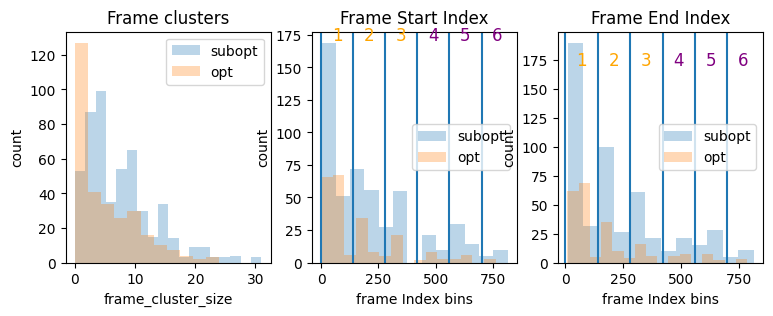

In [177]:
TOTAL_FRAMECOUNT = 840
TOTAL_SWEEPS = 6

def annotate_sweep_id(subplt_handle):
    [subplt_handle.axvline(x=int(frame_index)) for frame_index in range(0,TOTAL_FRAMECOUNT,int(TOTAL_FRAMECOUNT/TOTAL_SWEEPS))]
    for i,frame_index in enumerate(range(0,TOTAL_FRAMECOUNT,int(TOTAL_FRAMECOUNT/TOTAL_SWEEPS))):
        OFFSET = TOTAL_FRAMECOUNT / TOTAL_SWEEPS / 2
        x,y, = frame_index+OFFSET, 175
        color= 'orange' if i+1 in [1,2,3] else 'purple'
        subplt_handle.text(x, y, str(i+1), color=color, ha='center', va='center', fontsize=12)

fig,axes = plt.subplots(1,3,figsize =(9,3))
axes[0].hist(subopt_frame_count, bins='auto',alpha=0.3,label='subopt')  
axes[0].hist(opt_frame_counts, bins='auto',alpha =0.3,label='opt')  
axes[0].set_title("Frame clusters")
axes[0].set_xlabel('frame_cluster_size')
axes[0].set_ylabel('count')
axes[0].legend()

axes[1].hist(subopt_seqs_start, bins='auto',alpha=0.3,label='subopt')  
axes[1].hist(opt_seqs_start, bins='auto',alpha =0.3,label='opt')  
axes[1].set_title("Frame Start Index")
axes[1].set_xlabel('frame Index bins')
axes[1].set_ylabel('count')
annotate_sweep_id(axes[1])
axes[1].legend()

axes[2].hist(subopt_seqs_end, bins='auto',alpha=0.3,label='subopt')  
axes[2].hist(opt_seqs_end, bins='auto',alpha =0.3,label='opt')  
axes[2].set_title("Frame End Index")
axes[2].set_xlabel('frame Index bins')
axes[2].set_ylabel('count')
annotate_sweep_id(axes[2])
axes[2].legend()
plt.show()

<img src="https://rumc-gcorg-p-public.s3.amazonaws.com/i/2024/04/20/image.png" alt="Description" width="300">


In [180]:
TOTAL_FRAMECOUNT / TOTAL_SWEEPS

140.0

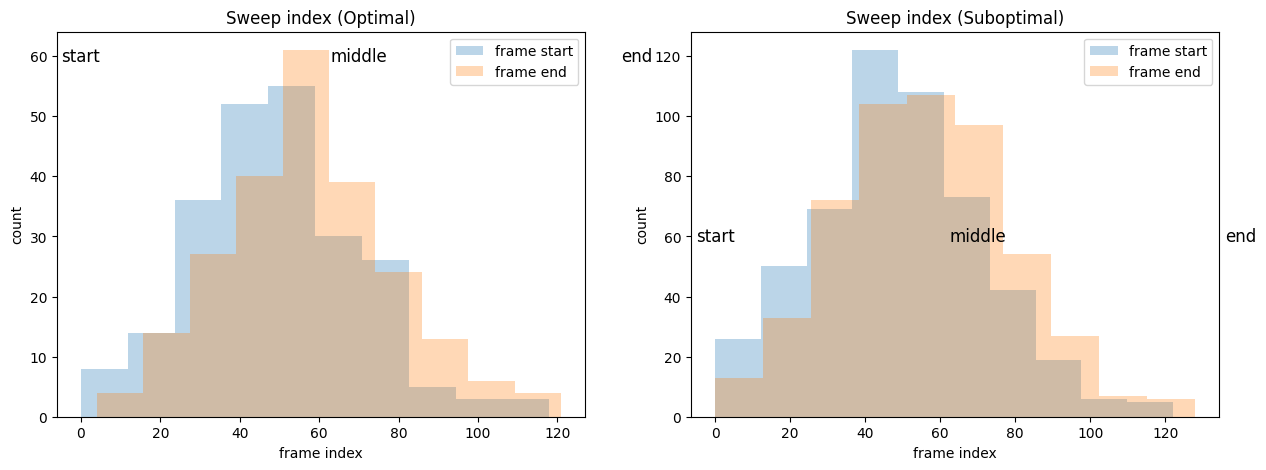

In [200]:
def annotate_sweep_region(subplt_handle):
    for i,(frame_index,text) in enumerate(zip(
        np.linspace(0,TOTAL_FRAMECOUNT / TOTAL_SWEEPS,3),
        ['start','middle','end'])
    ):
        x,y, = frame_index, 60
        subplt_handle.text(x, y, text, color='black', ha='center', va='center', fontsize=12)

fig, axes  = plt.subplots(1,2,figsize=(15,5))
axes[0].hist(np.array(opt_seqs_start) % (TOTAL_FRAMECOUNT / TOTAL_SWEEPS), alpha=0.3 ,label='frame start')
axes[0].hist(np.array(opt_seqs_end) % (TOTAL_FRAMECOUNT / TOTAL_SWEEPS),alpha=0.3, label='frame end')
axes[0].set_xlabel('frame index')
axes[0].set_ylabel('count')
axes[0].set_title('Sweep index (Optimal)')
annotate_sweep_region(axes[0])
axes[0].legend()

axes[1].hist(np.array(subopt_seqs_start) % (TOTAL_FRAMECOUNT / TOTAL_SWEEPS), alpha=0.3 ,label='frame start')
axes[1].hist(np.array(subopt_seqs_end) % (TOTAL_FRAMECOUNT / TOTAL_SWEEPS),alpha=0.3, label='frame end')
axes[1].set_xlabel('frame index')
axes[1].set_ylabel('count')
axes[1].set_title('Sweep index (Suboptimal)')
annotate_sweep_region(axes[1])
axes[1].legend()